様々な言語の Spell と Sound (IPA) の構造を LDA で探索する
黒田　航　(kow.kuroda@gmail.com)

2024/03/26 i. FastText のエンコードを追加; ii. UMAP を使った次元圧縮を追加

In [1574]:
## imports
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
#from functools import reduce

設定

In [1575]:
## 処理設定
verbose = False

## 全言語をカバーできる色パレットの用意
import plotly
color_palette = plotly.colors.qualitative.Dark24

In [1576]:
### LDA 用 (FastText と併用可能)
use_LDA = True

## トピック数
n_topics      = 9 # 30は多過ぎる？

### DTM 構築: doc, term の設定
## doc
doc_type      = 'form'  # 変更不可
doc_attrs     = [ 'spell', 'sound' ]
doc_attr      = doc_attrs[0]
print(f"doc_attr: {doc_attr}")

## doc の長さの上限
max_doc_size  = 15
print(f"max_doc_size: {max_doc_size}")

## doc の長さの下限
min_doc_size  = 3
print(f"min_doc_size: {min_doc_size}")

## ngram を包括的にするかどうか
ngram_is_inclusive = True

## term
term_size         = 'character' # 出力用の名目変数
#term_types        = re.split(r",\s+", "1gram, 2gram, 3gram, skippy2gram, skippy3gram")
term_types        = [ '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram' ]
lda_term_type     = term_types[-2]
print(f"lda_term_type: {lda_term_type}")

## term の最低頻度
term_min_freq = 2

## 高頻度 term の濫用指標: 大きくし過ぎないように．terms の異なりが小さいので0.03 は十分に大きい
term_abuse_threshold = 0.005

## skippy n-gram の表記
gap_mark = "…"

## skippy n-gram の結合範囲
max_ga_val = round(max_doc_size * 0.8)
print(f"max_ga_val for skippy n-grams: {max_ga_val}")

doc_attr: spell
max_doc_size: 15
min_doc_size: 3
lda_term_type: skippy2gram
max_ga_val for skippy n-grams: 12


In [1577]:
## FastText を使うか (LDA と併用可能)
use_FastText = False

## term
ft_term_types = [ '1gram', '2gram', '3gram', 'skippy2grm', 'skippy3gram' ]
ft_term_type = ft_term_types[2]
print(f"ft_term_type: {ft_term_type}")

## window size
ft_window_size = 5
print(f"ft_window_size: {ft_window_size}")

## dimension = vector size
ft_n_dims_factor = 2
ft_n_dims = round(n_topics * ft_n_dims_factor)
print(f"ft_n_dims: {ft_n_dims}")

ft_term_type: 3gram
ft_window_size: 5
ft_n_dims: 27


In [1578]:
## 確認

assert use_LDA or use_FastText
if use_LDA:
    if use_FastText:
        encoding_method = "LDA x FastText"
    else:
        encoding_method = "LDA"
else:
    encoding_method = "FastText"

In [1579]:
## tSNE 用

## 実行前にサンプリングするかどうか
doc_fit_sampling      = True
doc_fit_sampling_rate = 0.2

## perplexity を決めるパラメター
top_perplexity_reduct_rate = 0.5
#doc_perplexity_reduct_rate = 0.3 # 段階的に変化させる

In [1580]:
## UMAP の設定

## metric は correlation の他は良くない
umap_metrics     = [ 'correlation', 'cosine', 'euclidean', 'braycurtis', 'manhattan', 'minkowski' ]
umap_metric      = umap_metrics[0]

## n_neighbors
umap_n_neighbors = 6

## min_dist
umap_min_dist    = 0.3

In [ ]:
## DBSCAN clustering 用

dbscan_uses_UMAP = True # False ならtSNE を使う


# 言語の選別

In [1581]:
## 言語の選別
select_languages = True

## 言語の割合の均等化
balanced = True

## 色分けで言語名の変わりに語族を使う
color_lang_family = False

## 英語をゲルマン語に含める
germanic_includes_english = False

## スラブ語属を設定する
use_slavic = False # russian, czech を一緒にするのは条件付き

## ルーマニア語をロマンス語に含める
romance_includes_romanian = False

## ルーマニア語をスラブ語に含める
slavic_includes_romanian = False

In [1582]:
##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili

##綴り解析で使える言語
## arabic, bengali, chinese, czech, esperanto, english, finnish, french,
## galician, german, greek, hebrew, hungarian, icelandic, irish, italian,
## japanese, romanian, russian, spanish, swahili, turkish, welsh

import re
## sound sets
sound_set0 = "arabic, chinese, dutch, english, esperato, french, german, icelandic, japanese, korean, spanish, swahili"
sound_set1 = "arabic, dutch, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili"
#
sound_set_romance = "esperanto, french, galician, spanish"
sound_set_germanic = "english, german, icelandic"
sound_set_semitic = "arabic, hebrew"
sound_set_asian = "chinese, japanese, korean"

## spell sets
spell_set0 = "arabic, bengali, chinese, czech, dutch, esperato, english, finnish, french, \
    galician, german, greek, hebrew, hungarian, icelandic, irish, italian, japanese, korean, \
        romanian, russian, spanish, swahili, turkish, welsh"
spell_set1 = "arabic, czech, hebrew, dutch, english, esperanto, finnish, french, german, greek, \
    hungarian, icelandic, irish, romanian, russian, italian, spanish, swahili, turkish, welsh"
spell_set2 = "dutch, english, esperanto, french, finnish, german, hungarian, icelandic, irish, italian, \
    spanish, swahili, turkish, welsh"
spell_set3 = "dutch, english, esperanto, finnish, german, hungarian, irish, swahili, turkish, welsh"
#
spell_set_celtic     = "irish, welsh"
spell_set_celtic_x   = "irish, welsh, icelandic"
spell_set_germanic   = "dutch, german, icelandic"
spell_set_germanic_x = "dutch, english, german, icelandic"
spell_set_romance    = "esperanto, french, italian, spanish"
spell_set_romance_x  = "esperanto, french, italian, spanish, romanian"
spell_set_slavic     = "czech, russian"

## selection
selected_langs = re.split(r",\s*", spell_set_celtic_x + ", " + "dutch, english, french, german, hungarian, swahili, turkish")
print(f"selected {len(selected_langs)} languages:\n{selected_langs}")

selected 10 languages:
['irish', 'welsh', 'icelandic', 'dutch', 'english', 'french', 'german', 'hungarian', 'swahili', 'turkish']


In [1583]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
print(f"\n{target_dir} contains {len(target_files)} files to process")
if verbose:
    pp.pprint(target_files)


data-words contains 36 files to process


In [1584]:
import pandas as pd
## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_settings = { lang : 0 for lang in selected_langs }
print(f"{len(lang_settings.keys())} langs are targeted")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
10 langs are targeted
{'irish': 0, 'welsh': 0, 'icelandic': 0, 'dutch': 0, 'english': 0, 'french': 0, 'german': 0, 'hungarian': 0, 'swahili': 0, 'turkish': 0}
{'spell': 0, 'sound': 0, 'irish': 0, 'welsh': 0, 'icelandic': 0, 'dutch': 0, 'english': 0, 'french': 0, 'german': 0, 'hungarian': 0, 'swahili': 0, 'turkish': 0}


In [1585]:
## Obtain data from files
check = False
setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'irish', 'welsh', 'icelandic', 'dutch', 'english', 'french', 'german', 'hungarian', 'swahili', 'turkish']
reading: data-words/base-spell-Irish-r0-1k-mc.csv
reading: data-words/base-spell-Welsh-r0-1k-mc.csv
reading: data-words/base-sound-Icelandic-r0-1k-mc.csv
reading: data-words/base-spell-Icelandic-r0-original.csv
reading: data-words/base-sound-Dutch-r0-1k-mc.csv
reading: data-words/base-spell-Dutch-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-original.csv
reading: data-words/base-spell-Hungarian-r0-1k-mc.csv
reading: data-words/base-sound-Swahili-r0-1k-mc.csv
reading: data-words/base-spell-Swahili-r0-1k-mc.csv
rea

In [1586]:
## データ統合
raw_df = pd.concat(d_parts)
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,hungarian,swahili,turkish
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,0,0
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,0,0
2,a,1.0,1,0,1,0,0,0,0,0,0,0,0,0
3,go,1.0,1,0,1,0,0,0,0,0,0,0,0,0
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1.0,1,0,0,0,0,0,0,0,0,0,0,1
995,çoğul,1.0,1,0,0,0,0,0,0,0,0,0,0,1
996,öfke,1.0,1,0,0,0,0,0,0,0,0,0,0,1
997,iddia,1.0,1,0,0,0,0,0,0,0,0,0,0,1


In [1587]:
## form の小文字化
raw_df[doc_type] = raw_df[doc_type].apply(lambda x: x.lower())

In [1588]:
## 言語名= language の列を追加
check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(selected_langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,hungarian,swahili,turkish,language
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish
2,a,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish
3,go,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish
995,çoğul,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish
996,öfke,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish
997,iddia,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish


In [1589]:
## 言語族 family 列の追加
# germanic
if germanic_includes_english:
    germanic_langs = [ 'english', 'dutch', 'german', 'icelandic' ]
else:
    germanic_langs = [ 'dutch', 'german', 'icelandic' ]
# celtic
celtic_langs       = [ 'irish', 'welsh' ]
# romance
if romance_includes_romanian:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'romanian', 'italian', 'spanish' ]
else:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'italian', 'spanish' ]
# slavic
if use_slavic:
    if slavic_includes_romanian:
        slavic_langs   = [ 'czech', 'romanian', 'russian' ]
    else:
        slavic_langs   = [ 'czech', 'russian' ]
else:
    slavic_langs = [ ]
#
check = False
family_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    lang = row['language']
    if check:
        print(f"{i}: {lang}")
    # romance langs
    if lang in celtic_langs:
        family_vals.append('celtic')
    # romance langs
    elif lang in romance_langs:
        family_vals.append('romance')
    # germanic langs
    elif lang in germanic_langs:
        family_vals.append('germanic')
    # slavic langs
    elif lang in slavic_langs:
        family_vals.append('slavic')
    # all others
    else:
        family_vals.append(lang)
#
if verbose:
    print(family_vals)
    len(family_vals)
#
raw_df['family'] = family_vals
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,hungarian,swahili,turkish,language,family
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic
2,a,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic
3,go,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish
995,çoğul,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish
996,öfke,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish
997,iddia,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish


In [1590]:
## 文字数の列を追加
raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,hungarian,swahili,turkish,language,family,size
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,3
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,2
2,a,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,1
3,go,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,2
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5
995,çoğul,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5
996,öfke,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,4
997,iddia,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5


In [1591]:
## 解析データの型指定
print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: spell


,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,hungarian,swahili,turkish,language,family,size
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,3
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,2
2,a,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,1
3,go,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,2
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5
995,çoğul,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5
996,öfke,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,4
997,iddia,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5


In [1592]:
## 言語の選別
if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,hungarian,swahili,turkish,language,family,size
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,3
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,2
2,a,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,1
3,go,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,2
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5
995,çoğul,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5
996,öfke,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,4
997,iddia,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_61897/696675105.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



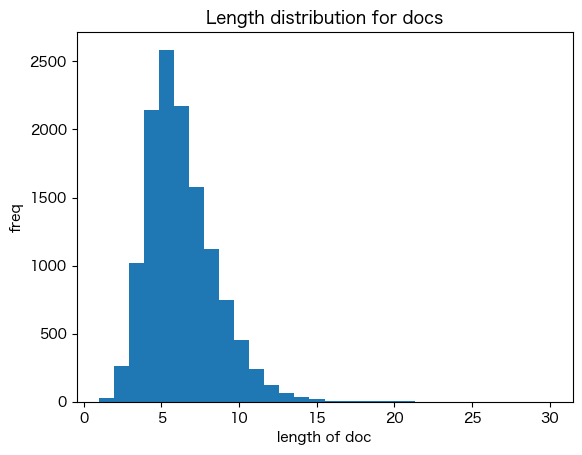

In [1593]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(raw_df['size'], bins = 30)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Length distribution for docs")
fig.show()

データを長さで濾過

In [1594]:
## 長過ぎる語の除外 
print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] <= max_doc_size]
max_filtered_size = len(raw_df)
print(f"{original_size - max_filtered_size} cases removed due to max_doc_size")

## 短過ぎる語の除外
print(f"min doc size: {min_doc_size}")
raw_df = raw_df[raw_df['size'] >= min_doc_size]
min_filtered_size = len(raw_df)
print(f"{max_filtered_size - min_filtered_size} cases removed due to min_doc_size")
#
print(f"{original_size - min_filtered_size} cases removed in total")

max doc size: 15
36 cases removed due to max_doc_size
min doc size: 3
287 cases removed due to min_doc_size
323 cases removed in total


In [1595]:
## 結果の検査 1
for type in types:
    print(raw_df[type].value_counts(sort = True))

spell
1    12304
Name: count, dtype: int64
sound
0    12304
Name: count, dtype: int64


In [1596]:
## 結果の検査 2
for lang in selected_langs:
    print(raw_df[lang].value_counts(sort = True).sort_index())

irish
0    11366
1      938
Name: count, dtype: int64
welsh
0    11333
1      971
Name: count, dtype: int64
icelandic
0    11480
1      824
Name: count, dtype: int64
dutch
0    11335
1      969
Name: count, dtype: int64
english
0    8059
1    4245
Name: count, dtype: int64
french
0    11336
1      968
Name: count, dtype: int64
german
0    11524
1      780
Name: count, dtype: int64
hungarian
0    11362
1      942
Name: count, dtype: int64
swahili
0    11604
1      700
Name: count, dtype: int64
turkish
0    11337
1      967
Name: count, dtype: int64


英語事例の割合補正

In [1597]:
## 統合: 割合補正を適用
eng_reduct_factor = 0.2
if balanced:
    try:
        eng_df = raw_df[raw_df['english'] == 1]
        non_eng_df = raw_df[raw_df['english'] == 0]
        eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
        raw_df = pd.concat([eng_reduced_df, non_eng_df])
    except KeyError:
        pass
#
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,hungarian,swahili,turkish,language,family,size
1767,heister,1.0,1,0,0,0,0,0,1,0,0,0,0,0,english,english,7
1655,grant,1.0,1,0,0,0,0,0,1,0,0,0,0,0,english,english,5
3951,try,1.0,1,0,0,0,0,0,1,0,0,0,0,0,english,english,3
2691,pain,1.0,1,0,0,0,0,0,1,0,0,0,0,0,english,english,4
4192,wing,1.0,1,0,0,0,0,0,1,0,0,0,0,0,english,english,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,burun,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5
995,çoğul,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5
996,öfke,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,4
997,iddia,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5


In [1598]:
## 結果の検査 3
for lang in selected_langs:
    print(raw_df[lang].value_counts().sort_index())

irish
0    7970
1     938
Name: count, dtype: int64
welsh
0    7937
1     971
Name: count, dtype: int64
icelandic
0    8084
1     824
Name: count, dtype: int64
dutch
0    7939
1     969
Name: count, dtype: int64
english
0    8059
1     849
Name: count, dtype: int64
french
0    7940
1     968
Name: count, dtype: int64
german
0    8128
1     780
Name: count, dtype: int64
hungarian
0    7966
1     942
Name: count, dtype: int64
swahili
0    8208
1     700
Name: count, dtype: int64
turkish
0    7941
1     967
Name: count, dtype: int64


# 解析

In [1599]:
## 順序のランダマイズし，基本データを決定
import sklearn.utils
main_df = sklearn.utils.shuffle(raw_df)

DTM 構築の準備

In [1600]:
## ngram の追加

## module 探索範囲の拡張
import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

# name the shared variable
bases = main_df[doc_type]

In [1601]:
## 1gram 列の追加
unigrams = ngrams.gen_unigrams(bases, sep = r"", check = False)
unigrams = [ [ u for u in L if len(u) > 0 ] for L in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
main_df['1gram'] = unigrams
main_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,hungarian,swahili,turkish,language,family,size,1gram
163,bu_yüzden,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,9,"[b, u, _, y, ü, z, d, e, n]"
327,court,1.0,1,0,0,0,0,0,0,1,0,0,0,0,french,romance,5,"[c, o, u, r, t]"
727,ystyried,1.0,1,0,0,1,0,0,0,0,0,0,0,0,welsh,celtic,8,"[y, s, t, y, r, i, e, d]"
822,radharc,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,7,"[r, a, d, h, a, r, c]"
783,radyo,1.0,1,0,0,0,0,0,0,0,0,0,0,1,turkish,turkish,5,"[r, a, d, y, o]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,ital,1.0,1,0,0,0,0,0,0,0,0,1,0,0,hungarian,hungarian,4,"[i, t, a, l]"
46,mondta,1.0,1,0,0,0,0,0,0,0,0,1,0,0,hungarian,hungarian,6,"[m, o, n, d, t, a]"
973,naoi,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,4,"[n, a, o, i]"
98,cré,1.0,1,0,1,0,0,0,0,0,0,0,0,0,irish,celtic,3,"[c, r, é]"


In [1602]:
## 2gram列の追加
bigrams = ngrams.gen_bigrams(bases, sep = r"", check = False)

## 包括的 2gram の作成
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]
#
if verbose:
    print(random.sample(bigrams, 3))

In [1603]:
main_df['2gram'] = bigrams
if verbose:
    main_df

In [1604]:
## 3gram列の追加
trigrams = ngrams.gen_trigrams(bases, sep = r"", check = False)

## 包括的 3gram の作成
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]
#
if verbose:
    print(random.sample(trigrams, 3))

In [1605]:
main_df['3gram'] = trigrams
if verbose:
    main_df

In [1606]:
## skippy 2grams の生成
import ngrams_skippy
skippy_2grams = [ ngrams_skippy.gen_skippy_bigrams(x, missing_mark = gap_mark,
                                                    max_distance = max_ga_val, check = False)
                  for x in main_df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
if verbose:
    random.sample(skippy_2grams, 3)

In [1607]:
## skippy 2gram 列の追加
main_df['skippy2gram'] = skippy_2grams
main_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,...,hungarian,swahili,turkish,language,family,size,1gram,2gram,3gram,skippy2gram
163,bu_yüzden,1.0,1,0,0,0,0,0,0,0,...,0,0,1,turkish,turkish,9,"[b, u, _, y, ü, z, d, e, n]","[bu, u_, _y, yü, üz, zd, de, en, b, u, _, y, ü...","[bu_, u_y, _yü, yüz, üzd, zde, den, bu, u_, _y...","[bu, b…_, b…y, b…ü, b…z, b…d, b…e, b…n, u_, u…..."
327,court,1.0,1,0,0,0,0,0,0,1,...,0,0,0,french,romance,5,"[c, o, u, r, t]","[co, ou, ur, rt, c, o, u, r, t]","[cou, our, urt, co, ou, ur, rt, c, o, u, r, t]","[co, c…u, c…r, c…t, ou, o…r, o…t, ur, u…t, rt,..."
727,ystyried,1.0,1,0,0,1,0,0,0,0,...,0,0,0,welsh,celtic,8,"[y, s, t, y, r, i, e, d]","[ys, st, ty, yr, ri, ie, ed, y, s, t, y, r, i,...","[yst, sty, tyr, yri, rie, ied, ys, st, ty, yr,...","[ys, y…t, y…y, y…r, y…i, y…e, y…d, st, s…y, s…..."
822,radharc,1.0,1,0,1,0,0,0,0,0,...,0,0,0,irish,celtic,7,"[r, a, d, h, a, r, c]","[ra, ad, dh, ha, ar, rc, r, a, d, h, a, r, c]","[rad, adh, dha, har, arc, ra, ad, dh, ha, ar, ...","[ra, r…d, r…h, r…a, r…r, r…c, ad, a…h, a…a, a…..."
783,radyo,1.0,1,0,0,0,0,0,0,0,...,0,0,1,turkish,turkish,5,"[r, a, d, y, o]","[ra, ad, dy, yo, r, a, d, y, o]","[rad, ady, dyo, ra, ad, dy, yo, r, a, d, y, o]","[ra, r…d, r…y, r…o, ad, a…y, a…o, dy, d…o, yo,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,ital,1.0,1,0,0,0,0,0,0,0,...,1,0,0,hungarian,hungarian,4,"[i, t, a, l]","[it, ta, al, i, t, a, l]","[ita, tal, it, ta, al, i, t, a, l]","[it, i…a, i…l, ta, t…l, al, i, t, a, l]"
46,mondta,1.0,1,0,0,0,0,0,0,0,...,1,0,0,hungarian,hungarian,6,"[m, o, n, d, t, a]","[mo, on, nd, dt, ta, m, o, n, d, t, a]","[mon, ond, ndt, dta, mo, on, nd, dt, ta, m, o,...","[mo, m…n, m…d, m…t, m…a, on, o…d, o…t, o…a, nd..."
973,naoi,1.0,1,0,1,0,0,0,0,0,...,0,0,0,irish,celtic,4,"[n, a, o, i]","[na, ao, oi, n, a, o, i]","[nao, aoi, na, ao, oi, n, a, o, i]","[na, n…o, n…i, ao, a…i, oi, n, a, o, i]"
98,cré,1.0,1,0,1,0,0,0,0,0,...,0,0,0,irish,celtic,3,"[c, r, é]","[cr, ré, c, r, é]","[cré, cr, ré, c, r, é]","[cr, c…é, ré, c, r, é]"


In [1608]:
## skippy 3grams の生成
import ngrams_skippy
skippy_3grams = [ ngrams_skippy.gen_skippy_trigrams(x, missing_mark = gap_mark,
                                                         max_distance = max_ga_val, check = False)
                  for x in main_df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
if verbose:
    random.sample(skippy_3grams, 3)

In [1609]:
## skippy 3gram 列の追加
main_df['skippy3gram'] = skippy_3grams
main_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,...,swahili,turkish,language,family,size,1gram,2gram,3gram,skippy2gram,skippy3gram
163,bu_yüzden,1.0,1,0,0,0,0,0,0,0,...,0,1,turkish,turkish,9,"[b, u, _, y, ü, z, d, e, n]","[bu, u_, _y, yü, üz, zd, de, en, b, u, _, y, ü...","[bu_, u_y, _yü, yüz, üzd, zde, den, bu, u_, _y...","[bu, b…_, b…y, b…ü, b…z, b…d, b…e, b…n, u_, u…...","[bu_, bu…y, bu…ü, bu…z, bu…d, bu…e, bu…n, b…_y..."
327,court,1.0,1,0,0,0,0,0,0,1,...,0,0,french,romance,5,"[c, o, u, r, t]","[co, ou, ur, rt, c, o, u, r, t]","[cou, our, urt, co, ou, ur, rt, c, o, u, r, t]","[co, c…u, c…r, c…t, ou, o…r, o…t, ur, u…t, rt,...","[cou, co…r, co…t, c…ur, c…u…t, c…rt, our, ou…t..."
727,ystyried,1.0,1,0,0,1,0,0,0,0,...,0,0,welsh,celtic,8,"[y, s, t, y, r, i, e, d]","[ys, st, ty, yr, ri, ie, ed, y, s, t, y, r, i,...","[yst, sty, tyr, yri, rie, ied, ys, st, ty, yr,...","[ys, y…t, y…y, y…r, y…i, y…e, y…d, st, s…y, s…...","[yst, ys…y, ys…r, ys…i, ys…e, ys…d, y…ty, y…t…..."
822,radharc,1.0,1,0,1,0,0,0,0,0,...,0,0,irish,celtic,7,"[r, a, d, h, a, r, c]","[ra, ad, dh, ha, ar, rc, r, a, d, h, a, r, c]","[rad, adh, dha, har, arc, ra, ad, dh, ha, ar, ...","[ra, r…d, r…h, r…a, r…r, r…c, ad, a…h, a…a, a…...","[rad, ra…h, ra…a, ra…r, ra…c, r…dh, r…d…a, r…d..."
783,radyo,1.0,1,0,0,0,0,0,0,0,...,0,1,turkish,turkish,5,"[r, a, d, y, o]","[ra, ad, dy, yo, r, a, d, y, o]","[rad, ady, dyo, ra, ad, dy, yo, r, a, d, y, o]","[ra, r…d, r…y, r…o, ad, a…y, a…o, dy, d…o, yo,...","[rad, ra…y, ra…o, r…dy, r…d…o, r…yo, ady, ad…o..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,ital,1.0,1,0,0,0,0,0,0,0,...,0,0,hungarian,hungarian,4,"[i, t, a, l]","[it, ta, al, i, t, a, l]","[ita, tal, it, ta, al, i, t, a, l]","[it, i…a, i…l, ta, t…l, al, i, t, a, l]","[ita, it…l, i…al, tal, it, i…a, i…l, ta, t…l, ..."
46,mondta,1.0,1,0,0,0,0,0,0,0,...,0,0,hungarian,hungarian,6,"[m, o, n, d, t, a]","[mo, on, nd, dt, ta, m, o, n, d, t, a]","[mon, ond, ndt, dta, mo, on, nd, dt, ta, m, o,...","[mo, m…n, m…d, m…t, m…a, on, o…d, o…t, o…a, nd...","[mon, mo…d, mo…t, mo…a, m…nd, m…n…t, m…n…a, m…..."
973,naoi,1.0,1,0,1,0,0,0,0,0,...,0,0,irish,celtic,4,"[n, a, o, i]","[na, ao, oi, n, a, o, i]","[nao, aoi, na, ao, oi, n, a, o, i]","[na, n…o, n…i, ao, a…i, oi, n, a, o, i]","[nao, na…i, n…oi, aoi, na, n…o, n…i, ao, a…i, ..."
98,cré,1.0,1,0,1,0,0,0,0,0,...,0,0,irish,celtic,3,"[c, r, é]","[cr, ré, c, r, é]","[cré, cr, ré, c, r, é]","[cr, c…é, ré, c, r, é]","[cré, cr, c…é, ré, c, r, é]"


DTM 構築

In [1610]:
## LDA 構築の基になる document-term matrix (dtm) を構築
from gensim.corpora.dictionary import Dictionary
bots = main_df[lda_term_type] # 後で参照するので変数化しておく
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<3188 unique tokens: ['_', '_y', '_…d', '_…e', '_…n']...>


In [1611]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 2
abuse filter: 0.005
Dictionary<1843 unique tokens: ['_y', '_…d', '_…e', '_…n', '_…z']...>


In [1612]:
## Corpus (gensim の用語では corpus) の構築
corpus = [ diction.doc2bow(bot) for bot in bots ]

## check
check = True
if verbose:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 8908


LDA モデルの構築

In [1613]:
## LDA モデルの構築

from gensim.models import LdaModel as LDAmodel
print(f"Building LDA model with n_topics: {n_topics}")
doc_lda = LDAmodel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(doc_lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 9
LdaModel<num_terms=3188, num_topics=9, decay=0.5, chunksize=2000>


In [1614]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in doc_lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,a,s,e,a,c,l,n,e,e
1,k,i,m,r,h,a,d,b,r
2,u,o,t,f,a,e,o,l,t
3,r,t,k,t,i,d,e,r,i
4,i,s…i,e…e,p,ch,i,g,i,n
5,k…a,is,s,o,t,n,a,o,er
6,m,l,m…e,y,e,u,w,n,e…e
7,a…a,r,l,l,r,la,i,t,v
8,ka,i…i,i,a…a,c…e,g,y,h,u
9,u…a,á,me,e,n,a…l,r,é,e…r


LDAvis の実行

In [1615]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = doc_lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
LDAvis_use_MMDS  = False
LDAvis_use_tSNE  = False
if LDAvis_use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)
elif LDAvis_use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [1616]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = doc_lda.get_topics()
if verbose:
    topic_dist

In [1617]:
## 検査 1: topic ごとに分布の和を取る
print(topic_dist.sum(axis = 1))

[0.99999994 0.99999994 1.         0.99999994 0.9999999  1.0000001
 1.         1.         1.        ]


In [1618]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常
print(topic_dist.sum())

9.0


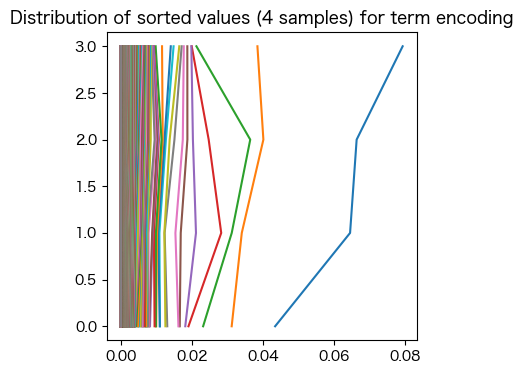

In [1619]:
## term エンコード値の分布を確認

import matplotlib.pyplot as plt

plt.figure(figsize = (4,4))
df_size = len(topic_dist)
sampling_rate = 0.5
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])
plt.plot(T, range(len(T)))
plt.title(f"Distribution of sorted values ({sample_n} samples) for term encoding")
plt.show()

In [1620]:
## tSNE を使った topics のグループ化 (3D)

from sklearn.manifold import TSNE as tSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
ppl_val = round(len(topic_dist) * top_perplexity_reduct_rate)
top_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = top_tSNE_3d.fit_transform(np.array(topic_dist))

In [1621]:
## Plotlyを使って tSNE の結果の可視化 (3D)

import plotly.graph_objects as go
top_fitted = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(
        x = top_fitted[:,0], y = top_fitted[:,1], z = top_fitted[:,2],
                                     mode = 'markers')
                                     ])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"t-SNE 3D map of LDA topics (#topics: {n_topics}; doc: {doc_attr}; term: {lda_term_type})"
fig.update_layout(autosize = False, width = 600, height = 600, title = title_val)
fig.show()

# doc 分類

In [1622]:
main_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,...,swahili,turkish,language,family,size,1gram,2gram,3gram,skippy2gram,skippy3gram
163,bu_yüzden,1.0,1,0,0,0,0,0,0,0,...,0,1,turkish,turkish,9,"[b, u, _, y, ü, z, d, e, n]","[bu, u_, _y, yü, üz, zd, de, en, b, u, _, y, ü...","[bu_, u_y, _yü, yüz, üzd, zde, den, bu, u_, _y...","[bu, b…_, b…y, b…ü, b…z, b…d, b…e, b…n, u_, u…...","[bu_, bu…y, bu…ü, bu…z, bu…d, bu…e, bu…n, b…_y..."
327,court,1.0,1,0,0,0,0,0,0,1,...,0,0,french,romance,5,"[c, o, u, r, t]","[co, ou, ur, rt, c, o, u, r, t]","[cou, our, urt, co, ou, ur, rt, c, o, u, r, t]","[co, c…u, c…r, c…t, ou, o…r, o…t, ur, u…t, rt,...","[cou, co…r, co…t, c…ur, c…u…t, c…rt, our, ou…t..."
727,ystyried,1.0,1,0,0,1,0,0,0,0,...,0,0,welsh,celtic,8,"[y, s, t, y, r, i, e, d]","[ys, st, ty, yr, ri, ie, ed, y, s, t, y, r, i,...","[yst, sty, tyr, yri, rie, ied, ys, st, ty, yr,...","[ys, y…t, y…y, y…r, y…i, y…e, y…d, st, s…y, s…...","[yst, ys…y, ys…r, ys…i, ys…e, ys…d, y…ty, y…t…..."
822,radharc,1.0,1,0,1,0,0,0,0,0,...,0,0,irish,celtic,7,"[r, a, d, h, a, r, c]","[ra, ad, dh, ha, ar, rc, r, a, d, h, a, r, c]","[rad, adh, dha, har, arc, ra, ad, dh, ha, ar, ...","[ra, r…d, r…h, r…a, r…r, r…c, ad, a…h, a…a, a…...","[rad, ra…h, ra…a, ra…r, ra…c, r…dh, r…d…a, r…d..."
783,radyo,1.0,1,0,0,0,0,0,0,0,...,0,1,turkish,turkish,5,"[r, a, d, y, o]","[ra, ad, dy, yo, r, a, d, y, o]","[rad, ady, dyo, ra, ad, dy, yo, r, a, d, y, o]","[ra, r…d, r…y, r…o, ad, a…y, a…o, dy, d…o, yo,...","[rad, ra…y, ra…o, r…dy, r…d…o, r…yo, ady, ad…o..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,ital,1.0,1,0,0,0,0,0,0,0,...,0,0,hungarian,hungarian,4,"[i, t, a, l]","[it, ta, al, i, t, a, l]","[ita, tal, it, ta, al, i, t, a, l]","[it, i…a, i…l, ta, t…l, al, i, t, a, l]","[ita, it…l, i…al, tal, it, i…a, i…l, ta, t…l, ..."
46,mondta,1.0,1,0,0,0,0,0,0,0,...,0,0,hungarian,hungarian,6,"[m, o, n, d, t, a]","[mo, on, nd, dt, ta, m, o, n, d, t, a]","[mon, ond, ndt, dta, mo, on, nd, dt, ta, m, o,...","[mo, m…n, m…d, m…t, m…a, on, o…d, o…t, o…a, nd...","[mon, mo…d, mo…t, mo…a, m…nd, m…n…t, m…n…a, m…..."
973,naoi,1.0,1,0,1,0,0,0,0,0,...,0,0,irish,celtic,4,"[n, a, o, i]","[na, ao, oi, n, a, o, i]","[nao, aoi, na, ao, oi, n, a, o, i]","[na, n…o, n…i, ao, a…i, oi, n, a, o, i]","[nao, na…i, n…oi, aoi, na, n…o, n…i, ao, a…i, ..."
98,cré,1.0,1,0,1,0,0,0,0,0,...,0,0,irish,celtic,3,"[c, r, é]","[cr, ré, c, r, é]","[cré, cr, ré, c, r, é]","[cr, c…é, ré, c, r, é]","[cré, cr, c…é, ré, c, r, é]"


In [1623]:
## LDA モデルを使って doc をエンコード

print(f"get LDA encodings for documents")
check    = False
lda_encoding = [ ]
for i, row in main_df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[lda_term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = doc_lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    lda_encoding.append([ e[-1] for e in enc ])
#
print(random.sample(lda_encoding, 2))
print(len(lda_encoding))

get LDA encodings for documents
[[0.0009914241, 0.40638033, 0.0009914241, 0.0009914241, 0.0009914241, 0.0009914241, 0.0009914241, 0.5866797, 0.0009914241], [0.0006628305, 0.99469733, 0.0006628305, 0.0006628305, 0.0006628305, 0.0006628305, 0.0006628305, 0.0006628305, 0.0006628305]]
8908


In [1624]:
## FastText を使ったエンコードの準備
from gensim.models import FastText

## build a model: for better comparison, vector_size should be equal to n_topics
print(f"get FastText encodings for documents")

#ft_corpus = df[doc_type]
## emulate sentences by concatenating character 1-grams by whitespaces
ft_corpus = [ " ".join(x) for x in main_df[ft_term_type] ]
random.sample(ft_corpus, 3)


get FastText encodings for documents


['yer ye er y e r', 'dağ da ağ d a ğ', 'cia ial all ci ia al ll c i a l l']

In [1625]:
## FastText を使ったエンコード
ft_model = FastText(ft_corpus,
                    vector_size = ft_n_dims,
                    window = ft_window_size,
                    min_count = 1, sg = 1)
## ft_model は dict
ft_encoding = [ ft_model.wv[doc] for doc in ft_corpus ]
print(random.sample(ft_encoding, 1))
print(f"data size: {len(ft_encoding)}")

[array([-0.00160033, -0.00610275,  0.00773979,  0.00523674,  0.00400491,
        0.00402416,  0.00285276,  0.00152959,  0.0006839 , -0.00235632,
        0.00128888, -0.00018638,  0.00349764,  0.00325581,  0.0051449 ,
       -0.00302737,  0.00282161, -0.00297122,  0.00029577, -0.00288582,
        0.00046485, -0.00253963, -0.00079332, -0.00126303,  0.00829849,
       -0.00444131,  0.00122698], dtype=float32)]
data size: 8908


In [1626]:
## doc_encoding の選択

if use_FastText:
    if use_LDA: ## LDA x FastText
        doc_encoding = [ np.concatenate([x, y], dtype = object) for x, y in zip(lda_encoding, ft_encoding) ]
    else: ## FastText only
        doc_encoding = ft_encoding
else: ## LDA only
    doc_encoding = lda_encoding
#
print(random.sample(doc_encoding, 1))
print(f"data size: {len(doc_encoding)}")

[[0.0009915958, 0.2149116, 0.0009915958, 0.0009915958, 0.43651694, 0.0009915958, 0.0009915958, 0.34262186, 0.0009915958]]
data size: 8908


In [1627]:
## df にenc 列の追加
#df['enc'] = [ list(map(lambda x: x[1], y)) for y in doc_encoding ]
main_df['enc'] = doc_encoding
main_df['enc']

163     [0.00022309377, 0.00022309377, 0.00022309377, ...
327     [0.0006627227, 0.0006627227, 0.0006627227, 0.0...
727     [0.00030223833, 0.02016426, 0.00030223833, 0.0...
822     [0.0003691591, 0.0003691591, 0.0003691591, 0.0...
783     [0.00066273066, 0.00066273066, 0.00066273066, ...
                              ...                        
884     [0.000991119, 0.000991119, 0.000991119, 0.5887...
46      [0.00047418673, 0.00047418673, 0.00047418673, ...
973     [0.0009911613, 0.0009911613, 0.0009911613, 0.3...
98      [0.001642233, 0.001642233, 0.001642233, 0.0016...
3488    [0.00076398504, 0.00076398504, 0.00076398504, ...
Name: enc, Length: 8908, dtype: object

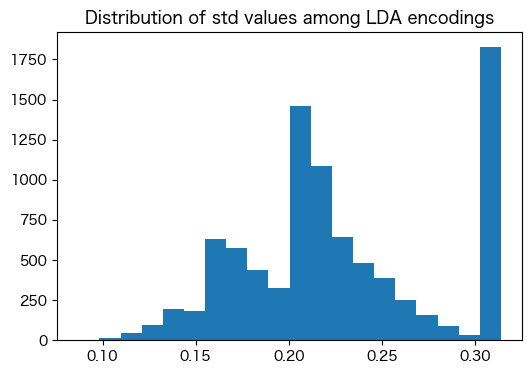

In [1628]:
## 濾過前のエンコーディングのstd の分布を確認

import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (6,4))
plt.hist([ np.std(x) for x in main_df['enc'] ], bins = 20)
plt.title(f"Distribution of std values among {encoding_method} encodings")
plt.show()

In [1629]:
## 一様分布の事例を除外

import numpy as np

check = False
doc_enc = main_df['enc']
max_std = max([ np.std(x) for x in doc_enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in doc_enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

std 1st min: 0.08695795387029648
std 2nd min: 0.3138542175292969


In [1630]:
## df_filtered の定義
import numpy as np

print(f"{len(main_df)} instances before filtering")

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 6 # 穏健な値を得るために 6で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if np.std(x) < std_threshold else True for x in main_df['enc'] ]
df_filtered = main_df[ std_tested ]
print(f"Filtering leaves {len(df_filtered)} instances: ({len(main_df) - len(df_filtered)} instances removed)")

8908 instances before filtering
std_threshold: 0.05230903625488281
Filtering leaves 8908 instances: (0 instances removed)


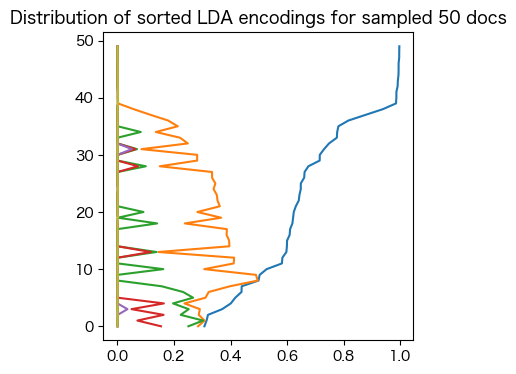

In [1631]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])
plt.figure(figsize = (4,4))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted {encoding_method} encodings for sampled {sample_n} docs")
plt.show()

In [1632]:
df_filtered['language'].value_counts(sort = True).sort_index()

language
dutch        969
english      849
french       968
german       780
hungarian    942
icelandic    824
irish        938
swahili      700
turkish      967
welsh        971
Name: count, dtype: int64

Dim Reduct 用の事例サンプリング

In [1633]:
## Dim Reduct 用の事例サンプリング = doc_fit_df の定義
if doc_fit_sampling:
    doc_fit_df_original = df_filtered.copy()
    sample_n = round(len(doc_fit_df_original) * doc_fit_sampling_rate)
    doc_fit_df = doc_fit_df_original.sample(sample_n)
    print(f"doc_fit_df has {len(doc_fit_df)} rows after sampling")
else:
    doc_fit_df = df_filtered

doc_fit_df has 1782 rows after sampling


In [1634]:
doc_fit_df.columns

Index(['form', 'freq', 'spell', 'sound', 'irish', 'welsh', 'icelandic',
       'dutch', 'english', 'french', 'german', 'hungarian', 'swahili',
       'turkish', 'language', 'family', 'size', '1gram', '2gram', '3gram',
       'skippy2gram', 'skippy3gram', 'enc'],
      dtype='object')

In [1635]:
doc_fit_df['language'].value_counts(sort = True).sort_index()

language
dutch        184
english      168
french       206
german       166
hungarian    206
icelandic    160
irish        180
swahili      135
turkish      177
welsh        200
Name: count, dtype: int64

In [1636]:
doc_fit_df['family'].value_counts(sort = True).sort_index()

family
celtic       380
english      168
germanic     510
hungarian    206
romance      206
swahili      135
turkish      177
Name: count, dtype: int64

UMAP を使った可視化 (3D)

In [1637]:
## UMAP を使った documents のグループ化

import numpy as np
import umap.umap_ as umap

## UMAP の生成
UMAP_3d = umap.UMAP(n_components = 3, random_state = 1, n_jobs = 1,
                    metric = umap_metric,
                    n_neighbors = umap_n_neighbors, min_dist = umap_min_dist)

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_UMAP_3d = UMAP_3d.fit_transform(doc_enc)

In [1638]:
%%capture --no-display

## Plotlyを使って UMAP の結果の可視化 (3D)
import plotly.graph_objects as go
import numpy as np

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family'
else:
    colored_var = 'language'
## umap_df を作成
X = zip(doc_UMAP_3d[:,0], doc_UMAP_3d[:,1], doc_UMAP_3d[:,2],
        doc_fit_df[colored_var], doc_fit_df[doc_type]) # zip(..)が必要
umap_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var, doc_type])
#
fig = go.Figure()
for lang_name in sorted(set(umap_df[colored_var])):
    # set marker size of the target domain
    traced = umap_df[ umap_df['language'] == lang_name ]
    fig.add_trace(
        go.Scatter3d(
            x = traced['D1'], y = traced['D2'], z = traced['D3'],
            name = lang_name.title(),
            mode = 'markers',
            marker = dict(size = 4, opacity = 0.8),
            marker_colorscale = color_palette, # worked??
            showlegend = True
        )
    )

## 3D 散布図にラベルを追加する処理は未実装
df_size = len(df)
## title_header
title_header = f"UMAP 3D (metric: {umap_metric}; {umap_n_neighbors} neighbors; min dist: {umap_min_dist}) of {df_size} encodings via\n"
## title_body
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term:0 {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
#
title_val = title_header + title_body
fig.update_layout(title = dict(text = title_val, font_size = 12), autosize = False, width = 700, height = 700)
fig.show()

t-SNE の結果の可視化 (3D)

In [1639]:
## tSNE の結果の可視化: Plotly を使った 3D 描画

import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定
max_perplexity_factor = 2
perplexity_max_val = round(len(doc_fit_df)/max_perplexity_factor)
print(f"perplexity_max_val: {perplexity_max_val}")

#perplexity_increment = 120
divider = 5
perplexity_increment = round(perplexity_max_val/divider)
print(f"perplexity_increment: {perplexity_increment}")

## tSNE を段階的に実行
df_size = len(doc_fit_df)
exit_after_step = 15
ppl_vals = enumerate(range(5, perplexity_max_val, perplexity_increment))
for step, ppl_val in ppl_vals:
    ## 早期終了の判定
    if step >= exit_after_step:
        continue
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val,
                          n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(doc_fit_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    ## 色分けの単位を選択
    if color_lang_family:
        colored_var = 'family'
    else:
        colored_var = 'language'
    ##
    X = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            doc_fit_df[colored_var]) # zip(..)が必要
    dfx = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])
    ## 作図
    fig = go.Figure()
    for lang in np.unique(main_df[colored_var]):
        traced = dfx[dfx[colored_var] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = traced['D1'], y = traced['D2'], z = traced['D3'],
                name = lang.title(), mode = 'markers', marker = dict(size = 3),
                marker_colorscale = color_palette, # worked??
                showlegend = True
            )
        )
    ## 題の指定
    title_header = f"t-SNE 3D map (ppl: {ppl_val}) of {df_size} encodings for <{doc_attr}> via\n"
    if use_FastText:
        if use_LDA:
            title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
        else:
            title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
    title_val = title_header + title_body
    fig.update_layout(title = dict(text = title_val, font_size = 13),
                      autosize = False, width = 600, height = 600)
    fig.show()

perplexity_max_val: 891
perplexity_increment: 178


In [1640]:
## 必要に応じて adjustText を道入
#!pip install -U adjustText

t-SNE の結果の可視化 (2D)

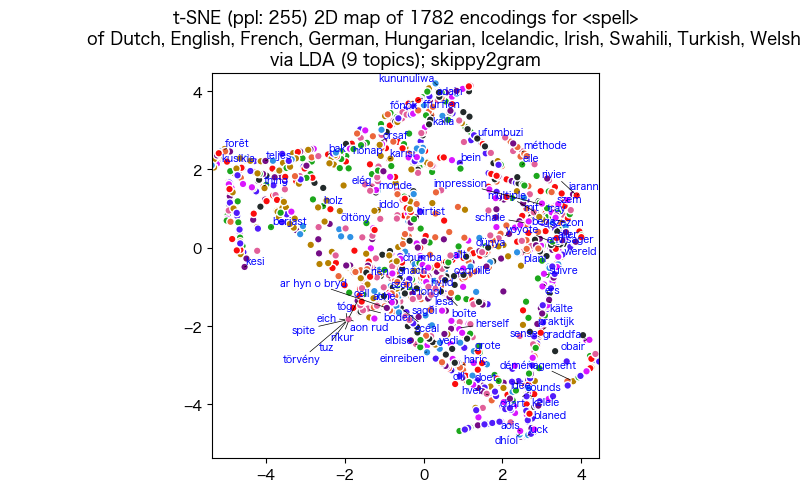

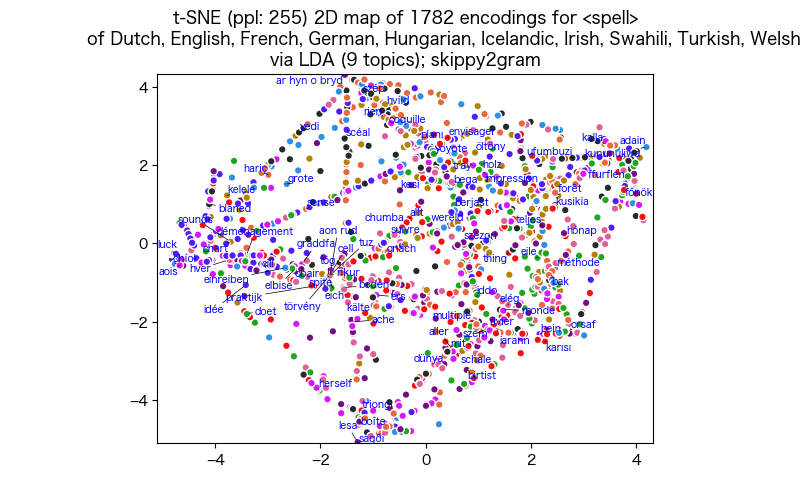

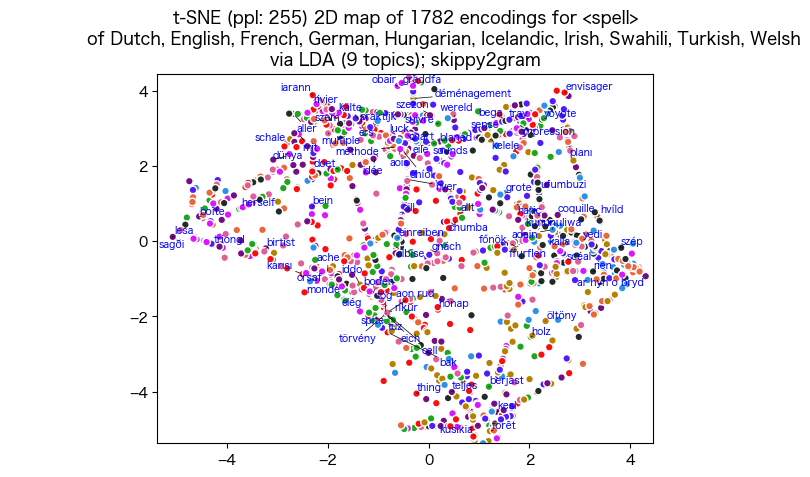

In [1646]:
## tSNE の結果の可視化 (2D)
#import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## tSNE 事例の生成
ppl_divider = 7
perplexity_selected = round(len(doc_fit_df)/ppl_divider)
doc_perplexity_val = perplexity_selected
doc_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family' # 一部の言語を celtic, germanic, romance, slavic 属に統合
else:
    colored_var = 'language' # 言語名そのまま

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_tSNE_3d = tSNE_3d.fit_transform(doc_enc)

## plot_df の定義
X = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2], doc_fit_df[colored_var]) # zip(..)が必要
plot_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])

## 描画
plt.figure(figsize = (5, 5))
## 配色
plt.set_colors = pex.colors.qualitative.Plotly
## labeling
lab_sampling_rate = 0.05
lab_sample_n = round(len(doc_fit_df) * lab_sampling_rate)
sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]    
##
check = False
early_exit = False
for step, roll in enumerate([ np.roll([0,1,2], -i) for i in range(0,3) ]):
    ## 早期停止の判定
    if early_exit:
        if step > 0:
            continue
    ## 通常処理
    if check:
        print(roll)
    X, Y = plot_df.iloc[:, roll[0]], plot_df.iloc[:, roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    ## 配色
    colormap = color_palette # == pex.colors.qualitative.Light24
    lang_list = list(set(doc_fit_df[colored_var]))
    cmapped = [ colormap[lang_list.index(lang)] for lang in plot_df[colored_var] ]
    
    ## 作図
    scatter = plt.scatter(X, Y, s = 30, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    texts = [ ]
    ## labels の生成
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
        ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        #force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    plt.title(f"t-SNE (ppl: {perplexity_selected}) 2D map of {len(doc_fit_df)} encodings for <{doc_attr}>\n\
              of {', '.join([ l.title() for l in sorted(selected_langs)])}\nvia LDA ({n_topics} topics); {lda_term_type}")
    #plt.legend(df['language'])
    plt.show()

In [1664]:
## DBSCAN を使ったクラスタリング

from sklearn.cluster import DBSCAN

if dbscan_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps は事例ごとに調節が必要
min_samples_val = 2
## looking for optimal eps val compatible with color palette
max_n_clusters = 24 # This depends on the differetiation in color palette used
dbscan_clustered = None
cluster_ids = None
print(f"Looking for the optimal eps val...")
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
for eps_val in eps_vals:
    print(f"testing eps = {eps_val:0.4f}")
    dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    cluster_ids_local = dbscan_clustered_local.labels_
    print(f"result: {np.unique(cluster_ids_local)}")
    try:
        assert len(np.unique(cluster_ids_local)) <= max_n_clusters
        dbscan_clustered = dbscan_clustered_local
        cluster_ids = cluster_ids_local
    except AssertionError:
        break
#
print(f"\nfinal result: {np.unique(cluster_ids)}")

Looking for the optimal eps val...
testing eps = 5.0000
result: [0 1 2]
testing eps = 4.9500
result: [0 1 2]
testing eps = 4.9000
result: [0 1 2]
testing eps = 4.8500
result: [0 1 2]
testing eps = 4.8000
result: [0 1 2]
testing eps = 4.7500
result: [0 1 2]
testing eps = 4.7000
result: [0 1 2]
testing eps = 4.6500
result: [0 1 2]
testing eps = 4.6000
result: [0 1 2]
testing eps = 4.5500
result: [0 1 2]
testing eps = 4.5000
result: [0 1 2]
testing eps = 4.4500
result: [0 1 2]
testing eps = 4.4000
result: [0 1 2]
testing eps = 4.3500
result: [0 1 2]
testing eps = 4.3000
result: [0 1 2]
testing eps = 4.2500
result: [0 1 2]
testing eps = 4.2000
result: [0 1 2]
testing eps = 4.1500
result: [0 1 2]
testing eps = 4.1000
result: [0 1 2]
testing eps = 4.0500
result: [0 1 2]
testing eps = 4.0000
result: [0 1 2]
testing eps = 3.9500
result: [0 1 2 3]
testing eps = 3.9000
result: [0 1 2 3]
testing eps = 3.8500
result: [0 1 2 3 4]
testing eps = 3.8000
result: [0 1 2 3 4]
testing eps = 3.7500
result:

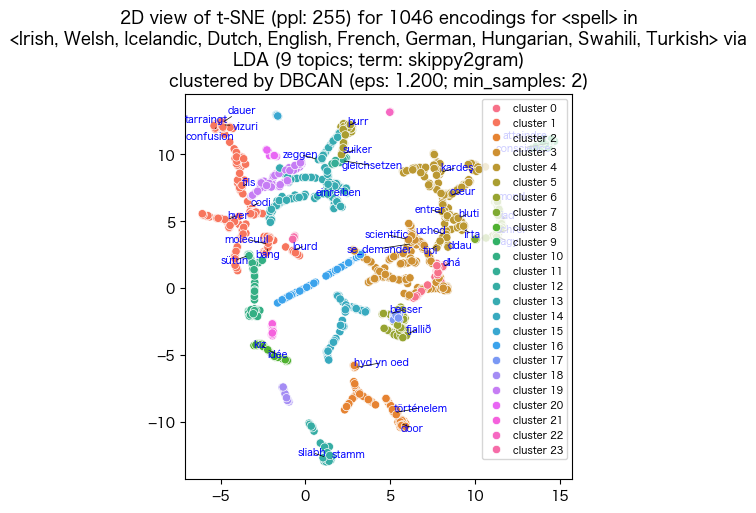

In [1667]:
%%capture --no-display

import seaborn as sns
import matplotlib.pyplot as plt

## 日本語表示のための設定
#plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定

## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)

## 描画
fig = plt.figure(figsize = (5, 5))
#
d1, d2 = dbscan_source[:,0], dbscan_source[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}" for l in dbscan_clustered.labels_ ]) # requires Searborn

## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.04 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(df))
else:
    lab_sample_n = 30 # 絶対数の指定

## 事例名の生成
texts = [ ]
sampled_keys = [ x[:max_doc_size] for x in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 7, color = 'blue'))

## label に repel を追加: adjustText package の導入が必要
adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    
## 題名を指定
## used_domains
used_langs = f"<{', '.join([ l.title() for l in selected_langs])}>"
## title_header
df_size = len(df)
if use_UMAP:
    title_header = f"2D view of UMAP (metric: {umap_metric}, n_neighbors: {umap_n_neighbors}; min_dist: {umap_min_dist}) for {df_size} encodings for <{doc_attr}> \nin {used_domains} via\n"
else:
    title_header = f"2D view of t-SNE (ppl: {doc_perplexity_val}) for {df_size} encodings for <{doc_attr}> in\n{used_langs} via\n"
## title_val
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_boday = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_val = f"LDA ({n_topics} topics; term: {lda_term_type})"
## clustering_method
clustering_method = f"\nclustered by DBCAN (eps: {eps_val:0.3f}; min_samples: {min_samples_val})"
#
title_val = title_header + title_body + clustering_method
plt.title(title_val)
plt.show()
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

階層クラスタリングのための部分サンプリングの追加

In [1644]:
## 階層クラスタリングのための事例のサンプリング

df_size = len(doc_fit_df)
hc_sampling_rate = 0.15 # 大きくし過ぎると図が見にくい
hc_sample_n = round(df_size * hc_sampling_rate)
doc_hc_df = doc_fit_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
doc_hc_df[colored_var].value_counts(sort = True).sort_index()

267 rows are sampled


language
dutch        18
english      23
french       34
german       28
hungarian    32
icelandic    25
irish        30
swahili      25
turkish      22
welsh        30
Name: count, dtype: int64

階層クラスタリングの実行

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 287 (\N{LATIN SMALL LETTER G WITH BREVE}) missing from current font.



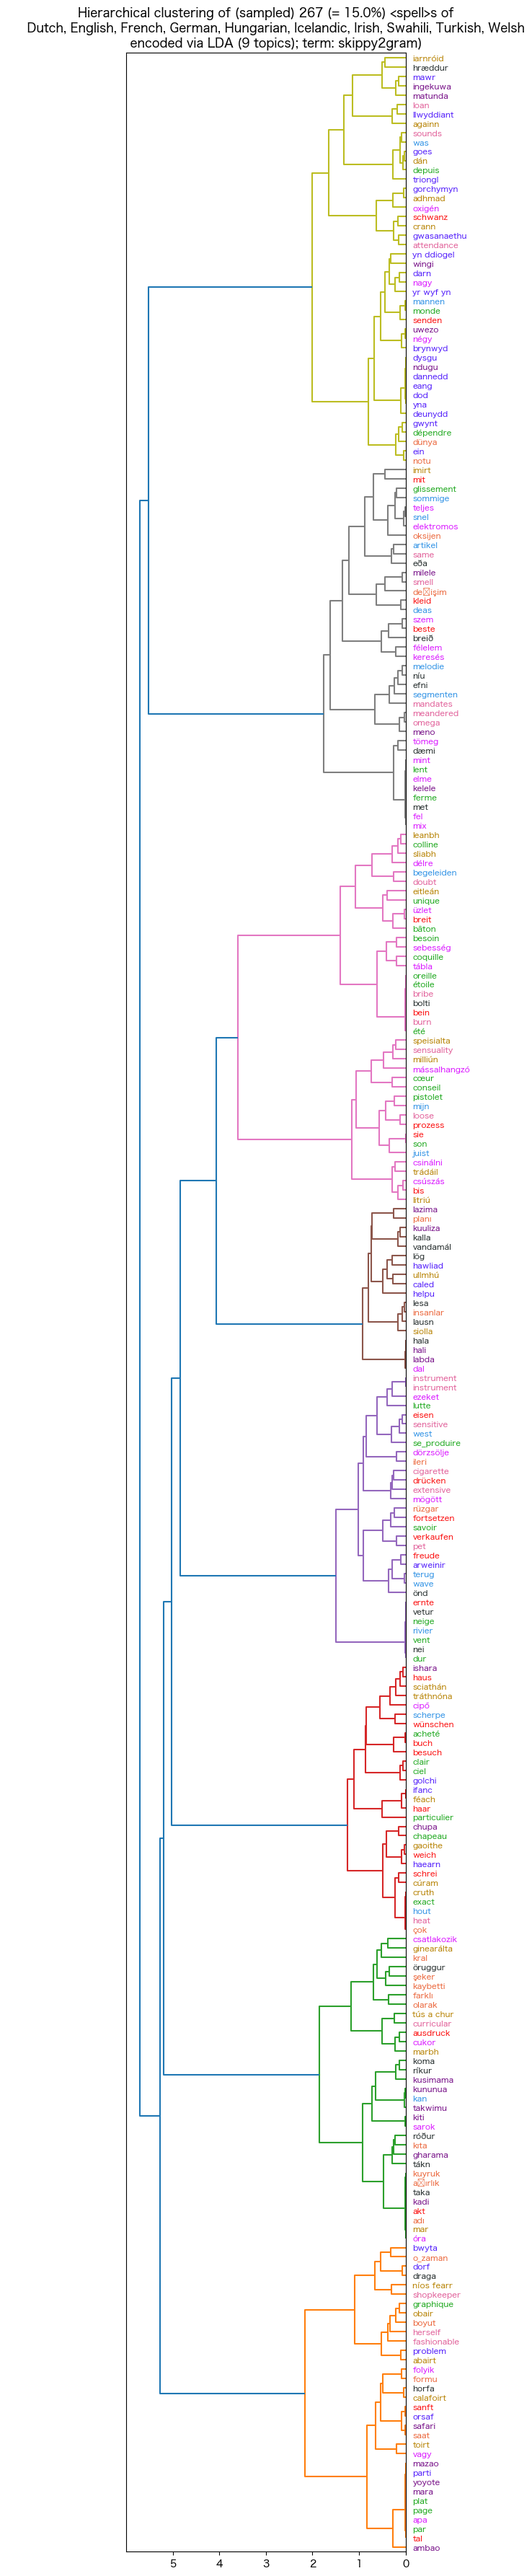

In [1645]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic, bengali が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## 描画サイズの指定
plt.figure(figsize = (5, round(len(doc_hc_df) * 0.17))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(doc_hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_hc_enc = list(doc_hc_df['enc'])
doc_linkage = linkage(doc_hc_enc, method = 'ward', metric = 'euclidean')
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(doc_hc_df)} (= {100 * hc_sampling_rate}%) <{doc_attr}>s of\n \
    {', '.join([ l.title() for l in sorted(selected_langs)])}\n \
    encoded via LDA ({n_topics} topics); term: {lda_term_type})")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(doc_hc_df[colored_var])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = doc_hc_df.loc[doc_hc_df[doc_type] == form]
    lang = row[colored_var].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(color_palette[lang_id])
#
plt.show()